# 도로 영역을 찾자! - 세그멘테이션 모델 만들기


In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

### Dataset load

- KITTI 데이터셋의 세그멘테이션 데이터 를 다운로드합니다. 
 http://www.cvlibs.net/datasets/kitti/eval_semantics.php
 
- 데이터 로더(data loader) 만들기
이제 이미지와 데이터셋이 주어졌으니 모델을 학습시킬 수 있는 데이터 로더(data loader)를 만들어봅시다. 로더는 입력값 (224, 224), 출력값 (224, 244) 크기를 갖는 모델을 학습시킬 수 있도록 데이터셋을 파싱 해야 합니다.

이때 데이터 로더에 augmentation 을 적용해 봅시다. 
오늘은 파이썬에서 많이 사용되는 albumentations을 사용해 보겠습니다. 하지만 Augmentation의 경우 imgaug 등 다른 라이브러리를 활용하셔도 됩니다.

- 입력값 (224, 224), 출력값 (224, 244) 크기를 갖는 모델을 학습시킬 수 있도록 데이터셋을 파싱
- 다양한 augmentation 기법을 확률적으로 적용할 수 있게 해주는 Albumentation의 Compose() 활용 (imgaug의 Sometimes()와 유사)
- tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터셋 구성
- 학습셋의 일정량을 validation dataset으로 활용

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                        HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                        RandomSizedCrop(          # 50%의 확률로 RandomSizedCrop
                            min_max_height=(300, 370),
                            w2h_ratio=370/1242,
                            height=224,
                            width=224,
                            p=0.5
                            ),
                        Resize(              # 입력이미지를 224X224로 resize
                            width=224,
                            height=224
                            )
                        ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다.
                Resize(
                    width=224,
                    height=224
                    )
                ])

Albumentation 의 사용법을 간단히 알아보겠습니다. 아래는 Albumentation에서 다양한 augmentation 기법을 확률적으로 적용할 수 있게 해주는 Compose()의 활용예입니다. imgaug의 Sometimes()와 유사한 기능입니다.

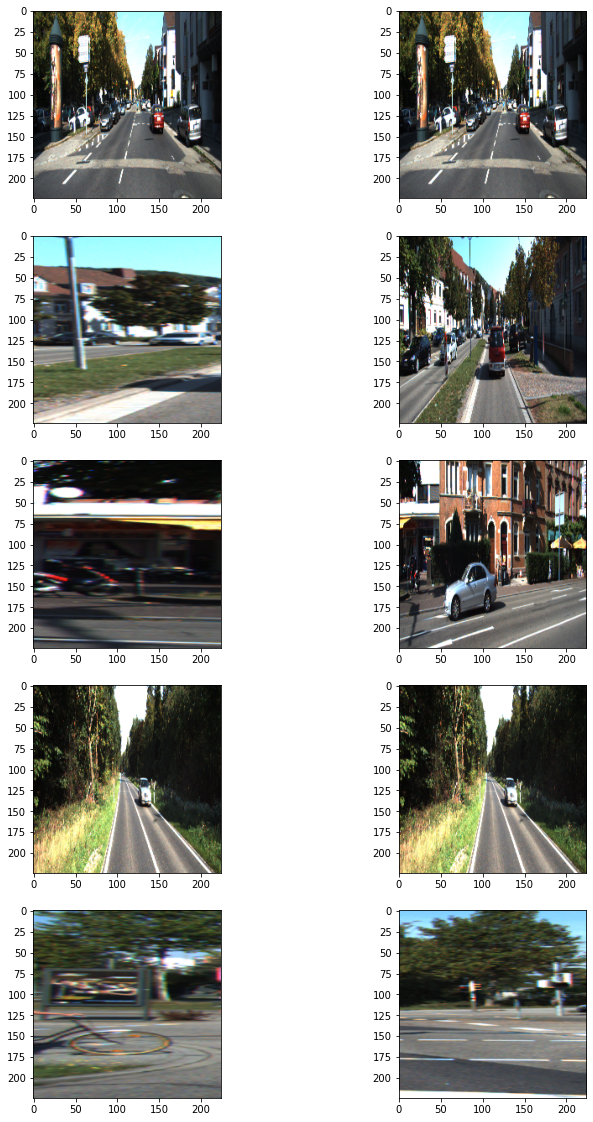

In [7]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.show()

In [9]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
               dir_path,
               batch_size=4,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
                }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [10]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## U-Net 구현
- Conv2D, UpSampling2D, MaxPooling2D, concatenate를 사용하여 구현
- 필요에 따라서 Dropout 등의 다른 레이어 적용 가능

In [12]:
def build_unet(input_shape=(224, 224, 3)):
    # input_shape에 따라 U-Net을 만들어주세요. 이때 model은 fully convolutional해야 합니다.
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

    # Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5)) 
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [26]:
unet = build_unet()
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 224, 224, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_66 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_65[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 112, 112, 64) 0           conv2d_66[0][0]                  
____________________________________________________________________________________________

In [27]:
unet.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
unet.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )
unet_path = './seg_model_unet.h5'
unet.save(unet_path)  # 학습한 모델을 저장해 주세요.


Epoch 1/100
43/43 [==============================] - 12s 247ms/step - loss: 0.3938 - val_loss: 0.1279
Epoch 2/100
43/43 [==============================] - 10s 240ms/step - loss: 0.1025 - val_loss: 0.0977
Epoch 3/100
43/43 [==============================] - 10s 242ms/step - loss: 0.0867 - val_loss: 0.0881
Epoch 4/100
43/43 [==============================] - 10s 243ms/step - loss: 0.0792 - val_loss: 0.0971
Epoch 5/100
43/43 [==============================] - 11s 245ms/step - loss: 0.0710 - val_loss: 0.0750
Epoch 6/100
43/43 [==============================] - 11s 246ms/step - loss: 0.0738 - val_loss: 0.0756
Epoch 7/100
43/43 [==============================] - 11s 248ms/step - loss: 0.0662 - val_loss: 0.0816
Epoch 8/100
43/43 [==============================] - 11s 249ms/step - loss: 0.0629 - val_loss: 0.0803
Epoch 9/100
43/43 [==============================] - 11s 250ms/step - loss: 0.0651 - val_loss: 0.0789
Epoch 10/100
43/43 [==============================] - 11s 251ms/step - loss: 0.067

In [16]:
def build_unet_pp(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    
    # X0,0
    conv0_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv0_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_0)
    pool0_0 = MaxPooling2D(pool_size=(2, 2))(conv0_0)
    # X1,0
    conv1_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool0_0)
    conv1_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_0)
    pool1_0 = MaxPooling2D(pool_size=(2, 2))(conv1_0)
    # X2,0
    conv2_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1_0)
    conv2_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_0)
    pool2_0 = MaxPooling2D(pool_size=(2, 2))(conv2_0)
    # X3,0
    conv3_0 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2_0)
    conv3_0 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_0)
    pool3_0 = MaxPooling2D(pool_size=(2, 2))(conv3_0)
    # X4,0
    conv4_0 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3_0)  
    conv4_0 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4_0)

    # X0,1
    up1_0 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_0)) 
    merge0_1 = concatenate([up1_0, conv0_0], axis = 3)
    conv0_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_1)
    conv0_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_1)
    # X1,1
    up2_0 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_0))
    merge1_1 = concatenate([up2_0, conv1_0], axis = 3)
    conv1_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_1)
    conv1_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_1)
    # X2,1
    up3_0 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3_0))
    merge2_1 = concatenate([up3_0, conv2_0], axis = 3)
    conv2_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_1)
    conv2_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_1)
    # X3,1
    up4_0 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv4_0))
    merge3_1 = concatenate([up4_0, conv3_0], axis = 3)
    conv3_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge3_1)
    conv3_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_1)  
    
    # X0,2
    up1_1 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_1)) 
    merge0_2 = concatenate([up1_1, conv0_0, conv0_1], axis = 3)
    conv0_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_2)
    conv0_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_2)
    # X1,2
    up2_1 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_1))
    merge1_2 = concatenate([up2_1, conv1_0, conv1_0], axis = 3)
    conv1_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_2)
    conv1_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_2)
    # X2,2
    up3_1 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3_1))
    merge2_2 = concatenate([up3_1, conv2_0, conv2_1], axis = 3)
    conv2_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_2)
    conv2_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_2)

    # X0,3
    up1_2 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_2)) 
    merge0_3 = concatenate([up1_2, conv0_0, conv0_1, conv0_2], axis = 3)
    conv0_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_3)
    conv0_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_3)
    # X1,3
    up2_2 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_2))
    merge1_3 = concatenate([up2_2, conv1_0, conv1_1, conv1_2], axis = 3)
    conv1_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_3)
    conv1_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_3)
    
    # X0,4
    up1_3 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_3)) 
    merge0_4 = concatenate([up1_3, conv0_0, conv0_1, conv0_2, conv0_3], axis = 3)
    conv0_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_4)
    conv0_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_4)
    
    output = Conv2D(1, 1, activation='sigmoid')(conv0_4)
    model = Model(inputs = inputs, outputs = output)
    
    return model


In [17]:
unet_pp = build_unet_pp()
unet_pp.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_24[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 112, 112, 64) 0           conv2d_25[0][0]                  
____________________________________________________________________________________________

In [18]:
unet_pp.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
unet_pp.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

unet_pp_path = './seg_model_unet_pp.h5'
unet_pp.save(unet_pp_path)  # 학습한 모델을 저장해 주세요.

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
43/43 [==============================] - 33s 595ms/step - loss: 0.4608 - val_loss: 0.1024
Epoch 2/100
43/43 [==============================] - 25s 581ms/step - loss: 0.1143 - val_loss: 0.1371
Epoch 3/100
43/43 [==============================] - 25s 592ms/step - loss: 0.1355 - val_loss: 0.0865
Epoch 4/100
43/43 [==============================] - 26s 604ms/step - loss: 0.0921 - val_loss: 0.0684
Epoch 5/100
43/43 [==============================] - 26s 610ms/step - loss: 0.0797 - val_loss: 0.0768
Epoch 6/100
43/43 [==============================] - 26s 607ms/step - loss: 0.0676 - val_loss: 0.0713
Epoch 7/100
43/43 [==============================] - 26s 612ms/step - loss: 0.0634 - val_loss: 0.0851
Epoch 8/100
43/43 [==============================] - 26s 616ms/step - loss: 0.0539 - val_loss: 0.0643
Epoch 9/100
43/43 [==============================] - 27s 618ms/step - loss: 0.0594 - val_loss: 0.0592
Epoch 10/100
43/43 [==============================] - 27s 617ms/step - loss: 0.055


### 시각화를 통한 정성적 비교

- 모델이 추론(inference)한 결과를 세그멘테이션 이미지로 만들어 확인
- 입력 이미지와 라벨을 한번에 볼 수 있도록 모델의 출력값을 입력 이미지 위에 오버레이(overray) 하기 (PIL의 Image.blend 활용)

In [28]:
unet_path = './seg_model_unet.h5'
unet_pp_path =  './seg_model_unet_pp.h5'

unet = tf.keras.models.load_model(unet_path)
unet_pp = tf.keras.models.load_model(unet_pp_path)

In [29]:
def get_output(model, preproc, image_path, output_path):
    # image_path로 입력된 이미지를 입력받아 preprocess를 해서 model로 infernece한 결과를 시각화하고 이를 output_path에 저장하는 함수
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  # 0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()

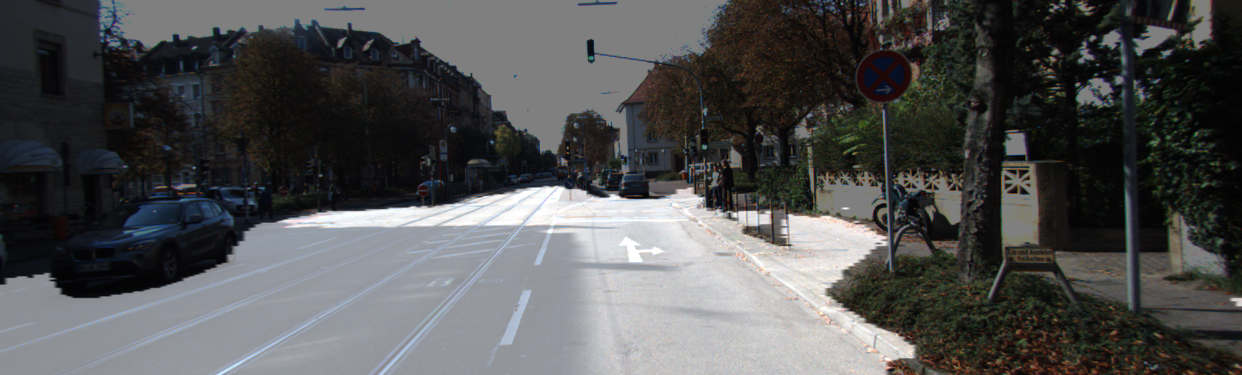

In [30]:
# U-Net 추론 결과 시각화
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

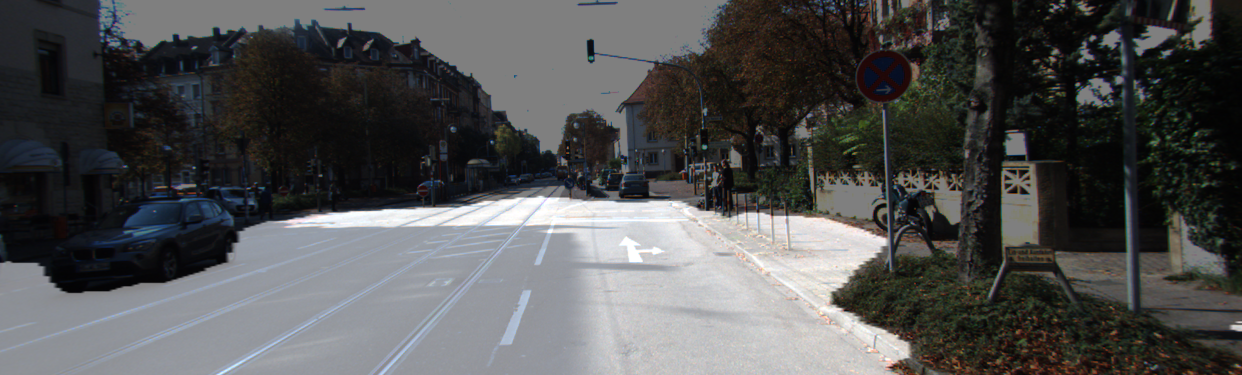

In [31]:
# U-Net++ 추론 결과 시각화
get_output(
     unet_pp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

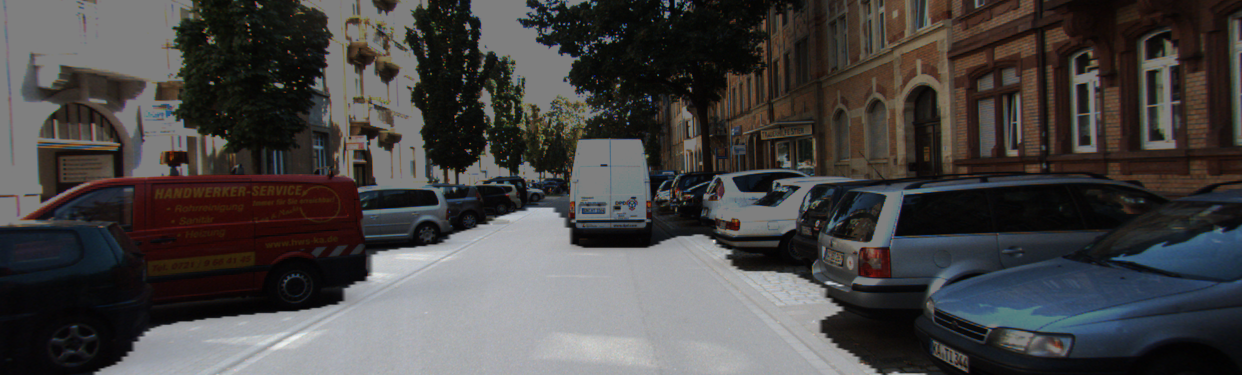

In [32]:
# U-Net 추론 결과 시각화
i = 5    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

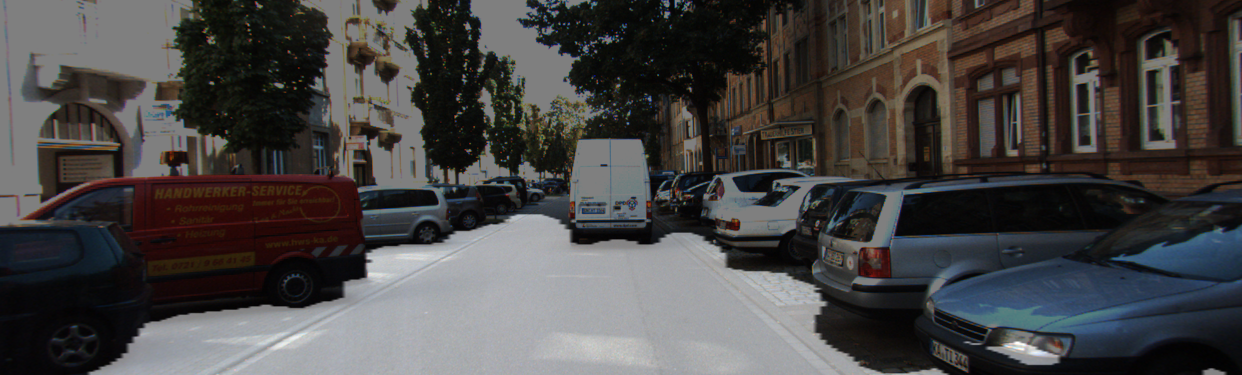

In [33]:
# U-Net++ 추론 결과 시각화
get_output(
     unet_pp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

### IoU 계산을 통한 정량적 비교

- prediction: 모델이 도로 영역이라고 판단한 부분이 1로, 나머지 부분이 0으로 표시된 행렬
- target: 라벨 데이터에서 도로 영역이 1, 나머지 부분이 0으로 표시된 행렬

위에 구현했던 get_output을 좀더 확장해서 output, prediction, target을 함께 리턴하도록 구현(plt.show()부분은 주석처리하였다.)

In [41]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    #print('IoU : %f' % iou_score )
    return iou_score

In [39]:
def get_output2(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    #output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [42]:
unet_iou = []
unet_pp_iou = []

for i in range(50):  # 이미지 50개로 테스트
    # U-Net의 IoU 계산
    output, prediction, target = get_output2(
         unet, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )

    unet_iou.append(calculate_iou_score(target, prediction))

    # U-Net++의 IoU 계산
    output, prediction, target = get_output2(
         unet_pp, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )

    unet_pp_iou.append(calculate_iou_score(target, prediction))

In [43]:
print('unet iou : \n',unet_iou)
print('unet_pp_iou : \n', unet_pp_iou)

unet iou : 
 [0.9258774630541872, 0.8754869325023019, 0.6230919765166341, 0.5591430295715147, 0.7135446685878962, 0.7229640322386623, 0.5920655454937473, 0.8087504143188597, 0.8356796676667436, 0.7768806273598606, 0.7816930651954678, 0.7762101678423741, 0.7234323847897255, 0.785996936430942, 0.7701217541213231, 0.8218776829453058, 0.8139234211834908, 0.8677974947807933, 0.7908954477238619, 0.869508053029473, 0.8135699899295066, 0.7718508997429306, 0.851706371473754, 0.8557610241820768, 0.6634099757584662, 0.6168499303081927, 0.538623461121388, 0.7968238213399503, 0.8856426468985065, 0.8469640644361834, 0.7917517751191518, 0.7926365264100269, 0.7927512355848435, 0.7892747885549757, 0.7448566906980834, 0.9359483051808185, 0.908899420747762, 0.9060006937218176, 0.8870593692022264, 0.8988903868090843, 0.9038947368421053, 0.917449892424414, 0.9037964208130754, 0.8363424306041521, 0.8392857142857143, 0.8294351955877847, 0.8055999612459429, 0.793476580615242, 0.7292563306976279, 0.73254793833

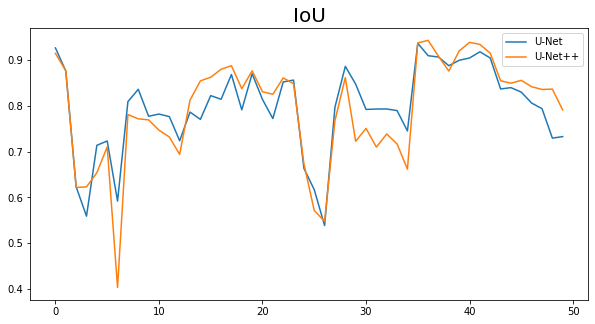

In [44]:
plt.figure(figsize=(10,5))
plt.plot(unet_iou)
plt.plot(unet_pp_iou)
plt.title('IoU', fontsize=20)
plt.legend(['U-Net', 'U-Net++'])
plt.show()

In [50]:
import pandas as pd
# IoU 평균 비교
df_iou = pd.DataFrame({'U-Net': unet_iou,
                       'U-Net++': unet_pp_iou})
df_iou.mean()

U-Net      0.796306
U-Net++    0.792293
dtype: float64


## 결과 분석

정석적 비교 :  
U-net++는 U-net과 육안으로 비교했을때 좀 더 디테일하게 픽셀을 잡아 도로를 segmentation하는 것을 느꼈다.
자동차 밑부분의 도로도 U-net++는 분리했고, 그냥 U-net은 분리하지 못했다. 하지만 멀리있는 도로는 U net이 더 잘 분리하였다.
U-net ++ 육안으로 보았을때 세밀하게 잘 분리하였다.

정량적 비교:   
정확한 비교를 위해 이미지 50개에 대한 두 모델의 IoU를 각각 계산하여 비교해보았다.
이미지 50개에 대한 IoU의 평균을 구해보니 U-Net은 796306 , U-Net++은 0.792293 정도로 U-Net이 조금더 정량적으로는 성능이 좋았다.

- 둘다 비슷해보이지만 정석적으로 보았을때 차가 많을때는 u-net++를 그렇지 않다면 U net을 쓰는게 조금더 나아보인다